In [2]:
import re
import string
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

In [3]:
train_df = pd.read_csv('../input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt', sep=":::", header=None, engine='python')
test_df = pd.read_csv('../input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data_solution.txt', sep=":::", header=None, engine='python')
train_df.columns=['id','title','genre','description']
test_df.columns=['id','title','genre','description']
train_df.head()

,id,title,genre,description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           54214 non-null  int64 
 1   title        54214 non-null  object
 2   genre        54214 non-null  object
 3   description  54214 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


In [5]:
train_df.isnull().sum()

id             0
title          0
genre          0
description    0
dtype: int64

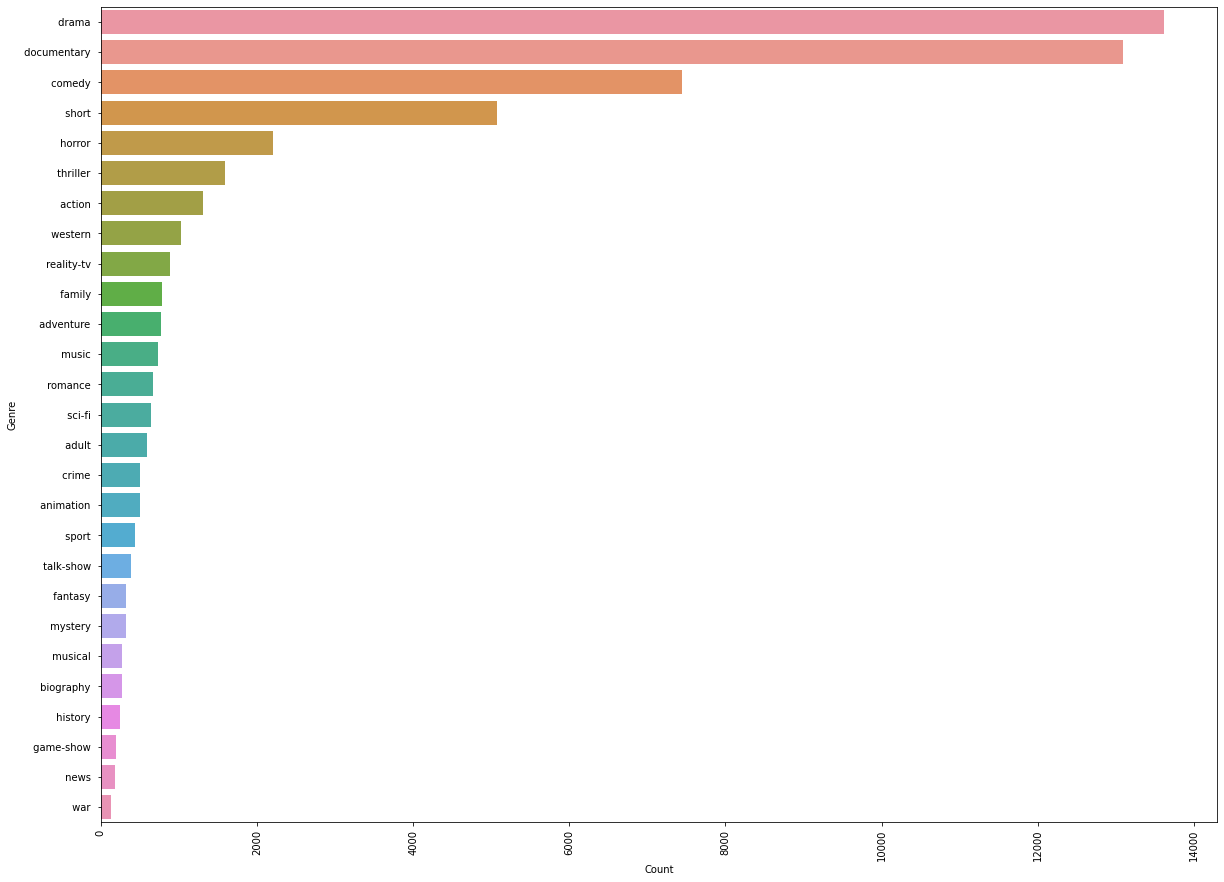

In [6]:
plt.figure(figsize=(20,15))
counts = train_df.genre.value_counts()
sns.barplot(x=counts, y=counts.index)
plt.xlabel('Count')
plt.ylabel('Genre')
plt.xticks(rotation=90);

In [10]:
train_df['length']=train_df['description'].apply(len)
train_df.head()

,id,title,genre,description,length
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625


<AxesSubplot:ylabel='Frequency'>

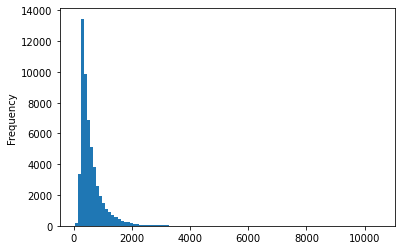

In [11]:
train_df['length'].plot(bins=100, kind='hist')

In [12]:
train_df.describe()

,id,length
count,54214.000000,54214.000000
mean,27107.500000,600.452429
std,15650.378084,446.026620
min,1.000000,42.000000
25%,13554.250000,325.000000
50%,27107.500000,464.000000
75%,40660.750000,713.000000
max,54214.000000,10504.000000


In [13]:
train_df[train_df['length']==42]['description']

52224     A buddy film set in the world of fashion.
Name: description, dtype: object

In [14]:
def clean_text(text):
    text = text.lower()                                  # lower-case all characters
    text =  re.sub(r'@\S+', '',text)                     # remove twitter handles
    text =  re.sub(r'http\S+', '',text)                  # remove urls
    text =  re.sub(r'pic.\S+', '',text) 
    text =  re.sub(r"[^a-zA-Z+']", ' ',text)             # only keeps characters
#     text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text+' ')      # keep words with length>1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.tokenize.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')   # remove stopwords
    text = " ".join([i for i in words if i not in stopwords])
    text= re.sub("\s[\s]+", " ",text).strip()            # remove repeated/leading/trailing spaces
    return text

In [15]:
train_df['Text_cleaning'] = train_df.description.apply(clean_text)
test_df['Text_cleaning'] = test_df.description.apply(clean_text)
test_df.head()

,id,title,genre,description,Text_cleaning
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar...",l r brane loves life car apartment job especia...
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch...",spain march quico naughty child three belongin...
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...,one year life albin family shepherds north tra...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi...",father died hasnt spoken brother years serious...
4,5,Er nu zhai (1955),drama,Before he was known internationally as a mart...,known internationally martial arts superstar b...


In [16]:
train_df['length_Text_cleaning']=train_df['Text_cleaning'].apply(len)
train_df.head()

,id,title,genre,description,length,Text_cleaning,length_Text_cleaning
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546,listening conversation doctor parents year old...,383
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184,brother sister past incestuous relationship cu...,119
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650,bus empties students field trip museum natural...,402
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082,help unemployed father make ends meet edith tw...,745
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625,films title refers un recovered bodies ground ...,405


In [17]:
num_words = 50000
max_len = 250
tokenizer = Tokenizer(num_words=num_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train_df['Text_cleaning'].values)

In [18]:
X = tokenizer.texts_to_sequences(train_df['Text_cleaning'].values)
X = pad_sequences(X, maxlen=max_len)
y = pd.get_dummies(train_df['genre']).values

X_test = tokenizer.texts_to_sequences(test_df['Text_cleaning'].values)
X_test = pad_sequences(X_test, maxlen=max_len)
y_test = pd.get_dummies(test_df['genre']).values

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(43371, 250)
(43371, 27)
(10843, 250)
(10843, 27)


In [21]:
EMBEDDING_DIM = 100
model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.1, recurrent_dropout=0.2))
model.add(Dense(27, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
my_callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0, patience=3, mode='auto'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
]

In [23]:
history = model.fit(X_train, y_train, epochs=5, batch_size=32,validation_data=(X_val,y_val), callbacks=my_callbacks)

Epoch 1/5
1356/1356 [==============================] - 1365s 1s/step - loss: 2.2275 - accuracy: 0.3464 - val_loss: 1.7065 - val_accuracy: 0.5079
Epoch 2/5
1356/1356 [==============================] - 1366s 1s/step - loss: 1.4677 - accuracy: 0.5825 - val_loss: 1.5641 - val_accuracy: 0.5465
Epoch 3/5
1356/1356 [==============================] - 1363s 1s/step - loss: 1.0779 - accuracy: 0.6910 - val_loss: 1.6178 - val_accuracy: 0.5471
Epoch 4/5
1356/1356 [==============================] - 1375s 1s/step - loss: 0.7671 - accuracy: 0.7814 - val_loss: 1.7720 - val_accuracy: 0.5409
Epoch 5/5
1356/1356 [==============================] - 1377s 1s/step - loss: 0.4776 - accuracy: 0.8676 - val_loss: 1.9818 - val_accuracy: 0.5355


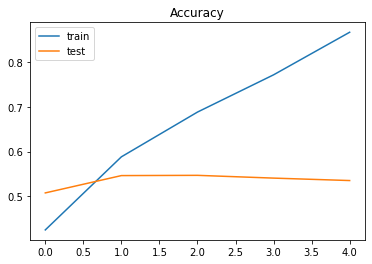

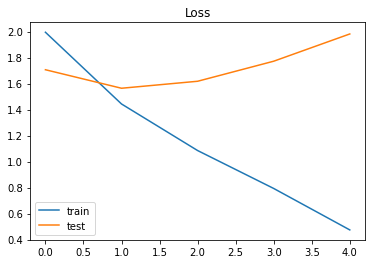

In [24]:
# Plotting Accuracy and val_accuracy
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

# Plotting loss and val_loss
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [25]:
results = model.evaluate(X_test, y_test, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 2.01992
Test Accuracy: 52.82%
